# Ordinals Financial Analysis
Eben Maré

30 January 2025

## Introduction
In what follows we perform statistical and financial analysis on Bitcoin Ordinal prices (and returns). We wish to look at return distributions, correlation with BTC, etc. in order to draw conclusions that might be helpful in assessing the value of ordinal collections.

The ordinals market is still relatively new, and not that well developed. There are a couple of marketplaces, of which Magic Eden is the biggest. There is limited data on bid prices, and instead collections have a floor prices (the lowest price at which an ordinal holder is willing to sell). In a regular market we would consider mid prices (the midpoint between the bid and ask price), but this is not readily available for ordinals. We have thus opted to use traded prices for the most liquid collections in Magic Eden. We think prices at which trades were executed are a better reflection of the market.


## Environment and Data

First off, load the packages that we will be using in this notebook and set variables to be used throughout.

In [71]:
# import all packages that will be used in the notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Toggle below to save images instead of showing them
save_results = False

We have sourced all the traded prices we could find (limited to 2100 trades per collection, by the API) for the five most liquid collections (where we could source adequate data) as at 30 January 2025. We also use Bitcoin price data. The data is available in the *data* folder. The collections are as follows (the names in parentheses will be used throughout, and these correspond to the collection Id's in Magic Eden):
- Bitcoin Puppets (bitcoin-puppets, https://magiceden.io/ordinals/marketplace/bitcoin-puppets)
- Quantum Cats (quantum_cats, https://magiceden.io/ordinals/marketplace/quantum_cats)
- NodeMonkes (nodemonkes, https://magiceden.io/ordinals/marketplace/nodemonkes)
- Ordinal Maxi Biz (omb, https://magiceden.io/ordinals/marketplace/omb)
- OCM Genesis (ocm-genesis, https://magiceden.io/ordinals/marketplace/ocm-genesis)

We load the data into dataframes (via pandas), which make various types of analysis easy, and then merge the data into a single dataframe for further consumption.

We also include a data file, larger_collection_price_history.csv, with more collections in there. You can try the below by changing the *data_file_name* variable below. You can also upload your own data file with the same format if you want to try different data.

In [72]:
# Load ordinal collection data and preprocess it
# This data contains the top NFT collection price history
data_file_name = "larger_collection_price_history"
collections_df = pd.read_csv('./data/{}.csv'.format(data_file_name),
                             usecols=['collection', 'date', 'price'],
                             parse_dates=['date'])  # Automatically parse 'date' columns as datetime
collections_df = collections_df.rename(columns={'price': 'collection_price'})  # Rename 'price' column for clarity
collections_df = collections_df.sort_values(by='date', ascending=True)  # Sort the data by 'date' in ascending order
collections_df['date'] = pd.to_datetime(collections_df['date'])  # Ensure 'date' column is in datetime format
collections_df['date'] = collections_df['date'].dt.tz_localize(None)  # Remove timezone information

# Load Bitcoin price data and preprocess it
# This dataset contains Bitcoin's daily closing prices
btc_df = pd.read_csv('./data/btc_price_data.csv',
                     usecols=['date', 'close'],
                     parse_dates=['date'],
                     dtype={'close': 'float64'},
                     date_format='%d-%b-%y')  # Specify date format for parsing
btc_df = btc_df.rename(columns={'close': 'btc_price'})  # Rename 'close' column for clarity
btc_df = btc_df.sort_values(by='date', ascending=True)  # Sort the data by 'date' in ascending order
btc_df['date'] = pd.to_datetime(btc_df['date'])  # Ensure 'date' column is in datetime format
btc_df['date'] = btc_df['date'].dt.tz_localize(None)  # Remove timezone information
btc_df['date'] = btc_df['date'].dt.date  # Convert datetime to date for consistency in merging
btc_df.set_index('date', inplace=True)  # Set 'date' as the index for easier mapping

# Convert the Bitcoin DataFrame to a dictionary for fast lookups during mapping
btc_price_dict = btc_df.to_dict(orient='dict')  # Convert to a nested dictionary with 'btc_price' as a top-level key

# Add 'btc_price' to the collections_df DataFrame by mapping 'btc_price' based on the 'date'
# Here, we use a lambda function to handle missing keys safely with the dictionary's get() method
collections_df['btc_price'] = collections_df['date'].map(
    lambda x: btc_price_dict['btc_price'].get(x.date())
)

Next, we plot all the prices (that we have in our data) over time.

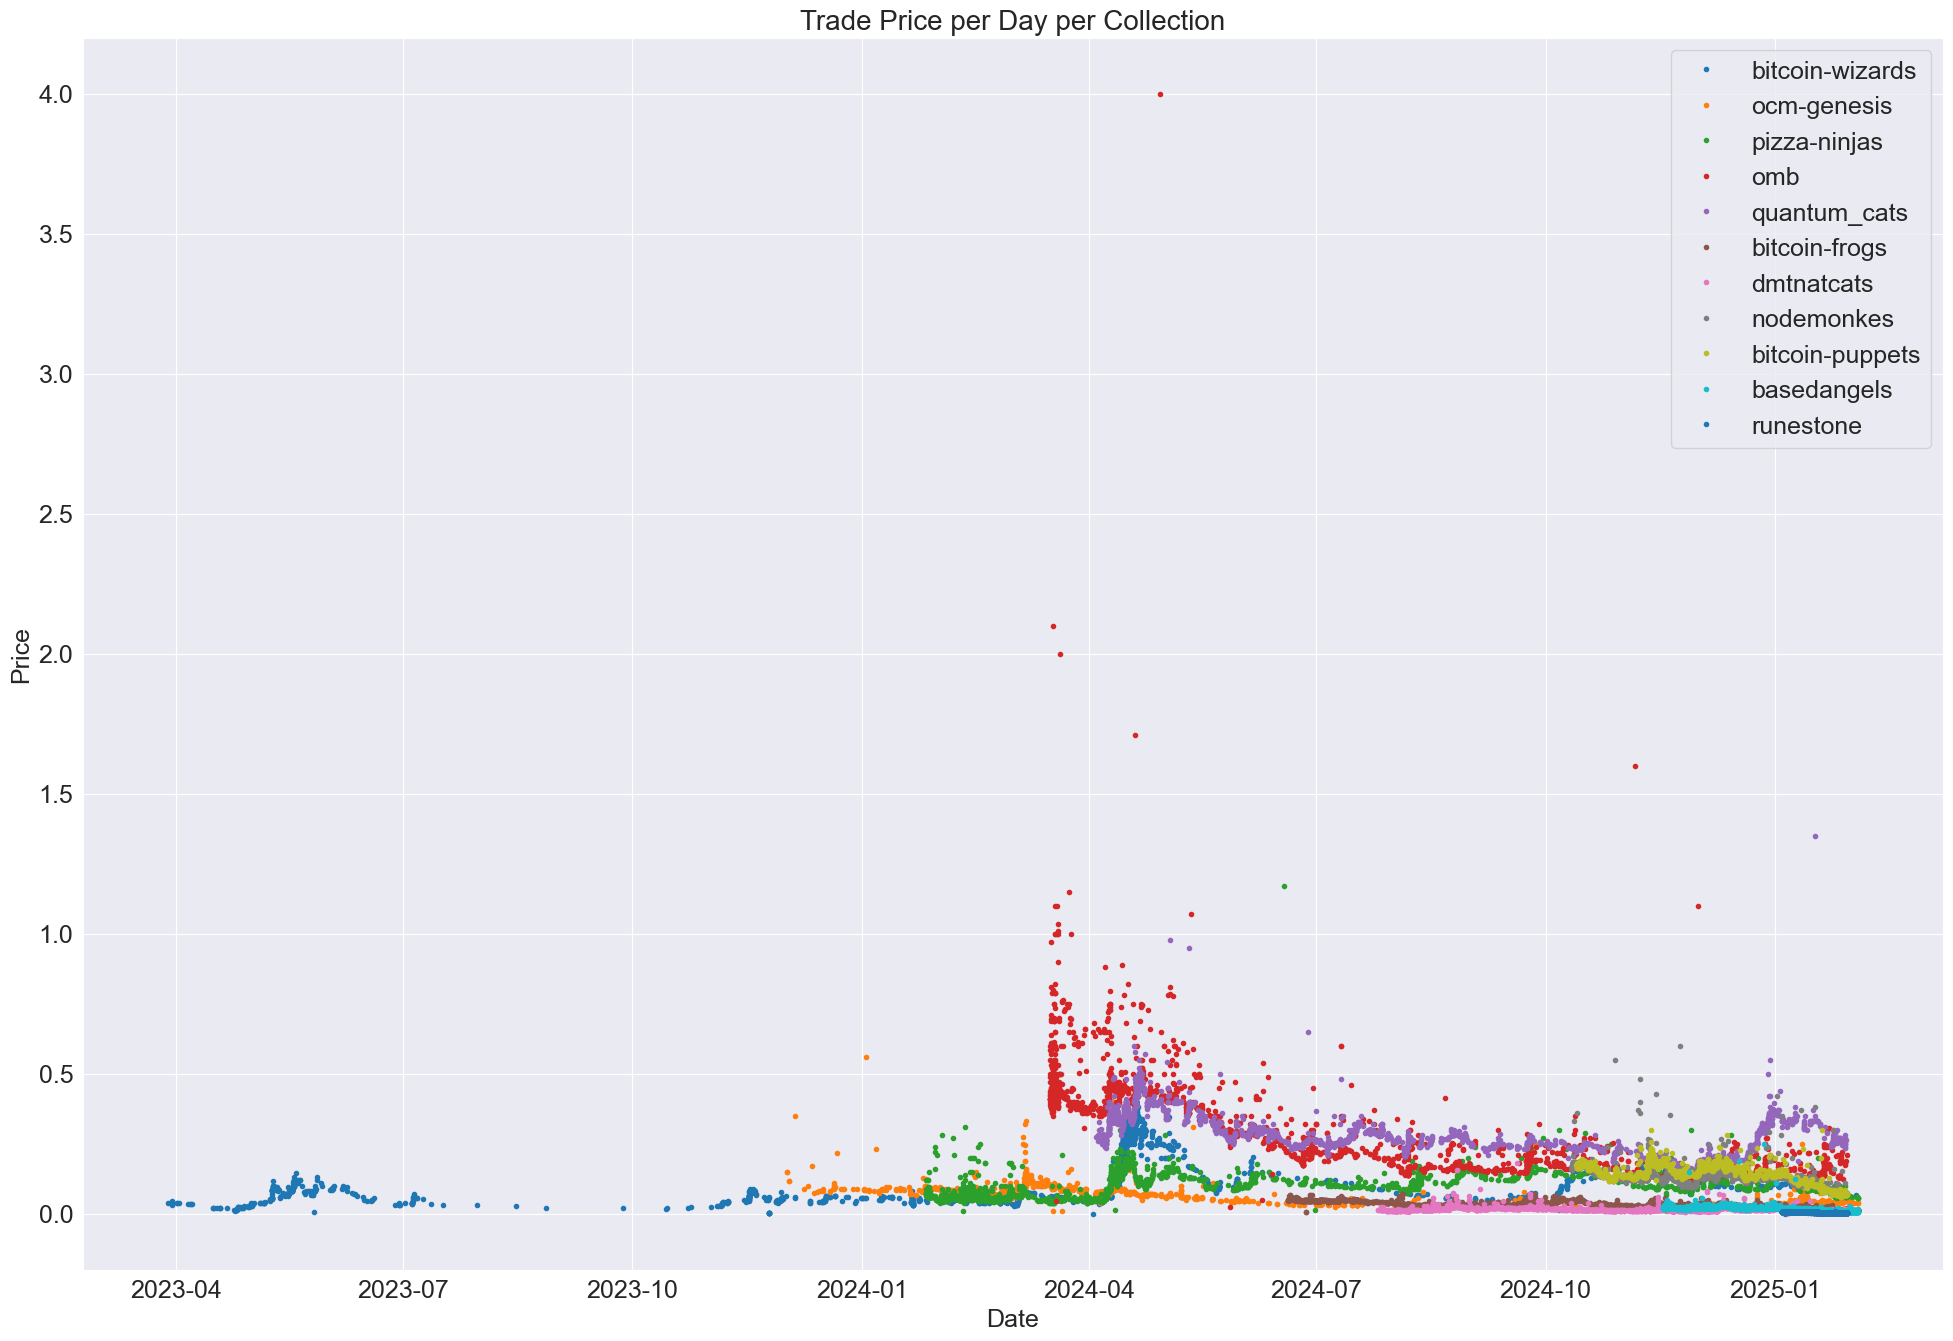

In [73]:
# Plot the traded prices for the collections
# This cell creates a visualization that shows the traded price of each NFT collection over time.

# Get a list of unique NFT collections from the 'collections_df' DataFrame
collections = collections_df['collection'].unique()

# Create a new figure with the specified size for the plot
plt.figure(figsize=(24, 16))

# Iterate over each unique NFT collection
for collection in collections:
    # Filter the DataFrame to include only the rows relevant to the current collection
    collection_data = collections_df[collections_df['collection'] == collection]

    # Plot the collection's traded price against the date
    # Each collection's prices are represented as a scatter plot with small circular markers
    plt.plot(
        collection_data['date'],
        collection_data['collection_price'],
        label=collection,
        marker='o',
        linestyle='',  # No line between points
        markersize=3
    )

# Label the x-axis as "Date" with increased font size
plt.xlabel('Date', fontsize=18)

# Label the y-axis as "Price" with increased font size
plt.ylabel('Price', fontsize=18)

# Add a title to the plot with increased font size
plt.title('Trade Price per Day per Collection', fontsize=20)

# Add a legend to the plot to identify each collection by its name and increase font size
plt.legend(fontsize=18)  # Adjusted fontsize to 16 for better visibility

# Add a grid to the plot for better readability of data points
plt.grid(True)

# Increase tick parameter sizes for both axes
plt.tick_params(axis='both', which='major', labelsize=18)

# Show/save plot
if save_results:
    plt.savefig('./results/trade_price_per_collection.png', dpi=300, bbox_inches='tight')
else:
    plt.show()

## Data analysis and resampling

From the above we can see that there are some outliers - these could be due to rare asset purchases, or other factors. For this analysis, we are interested in an market "price" of the collection (there is no single price, only prices for each of the assets). To this end, trades that are executed at prices significantly different to other trades at the same time, are considered outliers, and we're going to look at median prices over a suitable rolling window period (e.g., every 3-days).

You are welcome to change the *resample_period* variable below, e.g., to 2D for two-days, to look at the impact of this.

In [74]:
# Define a function to do the resampling
def resample_df(data_frame, period):
    # Create a copy to work on
    new_data_frame = data_frame.copy()

    # Resample the collections DataFrame to compute median prices over the specified time intervals
    new_data_frame = (
        new_data_frame
        .set_index(['date', 'collection'])  # Temporarily set 'date' and 'collection' as the index for easier resampling
        .groupby('collection')  # Group the data by 'collection' to ensure each collection is treated individually
        .resample(period, level='date')  # Resample based on 'date' using the defined time interval
        .median()  # Compute the median values for each group
        .reset_index()  # Reset the index back to a standard DataFrame format
    )

    # Calculate the Bitcoin log returns:
    # Transform each collection's Bitcoin prices to compute log returns (natural log price changes)
    new_data_frame['btc_log_return'] = new_data_frame.groupby('collection')['btc_price']\
        .transform(lambda x: np.log(x / x.shift(1)))

    # Calculate the collection log returns:
    # Transform each collection's traded prices to compute their log returns
    new_data_frame['collection_log_return'] = new_data_frame.groupby('collection')['collection_price']\
        .transform(lambda x: np.log(x / x.shift(1)))

    # Calculate the traded price of each collection in USD:
    # Multiply the collection's price in BTC by the corresponding BTC-to-USD price
    new_data_frame['collection_usd_price'] = new_data_frame['collection_price'] * new_data_frame['btc_price']

    # Calculate the Log Return in USD
    # Multiply the collection's price in BTC by the corresponding BTC-to-USD price
    new_data_frame['collection_usd_log_return'] = new_data_frame.groupby('collection')['collection_usd_price']\
        .transform(lambda x: np.log(x / x.shift(1)))


    return new_data_frame


<Figure size 2400x1600 with 0 Axes>

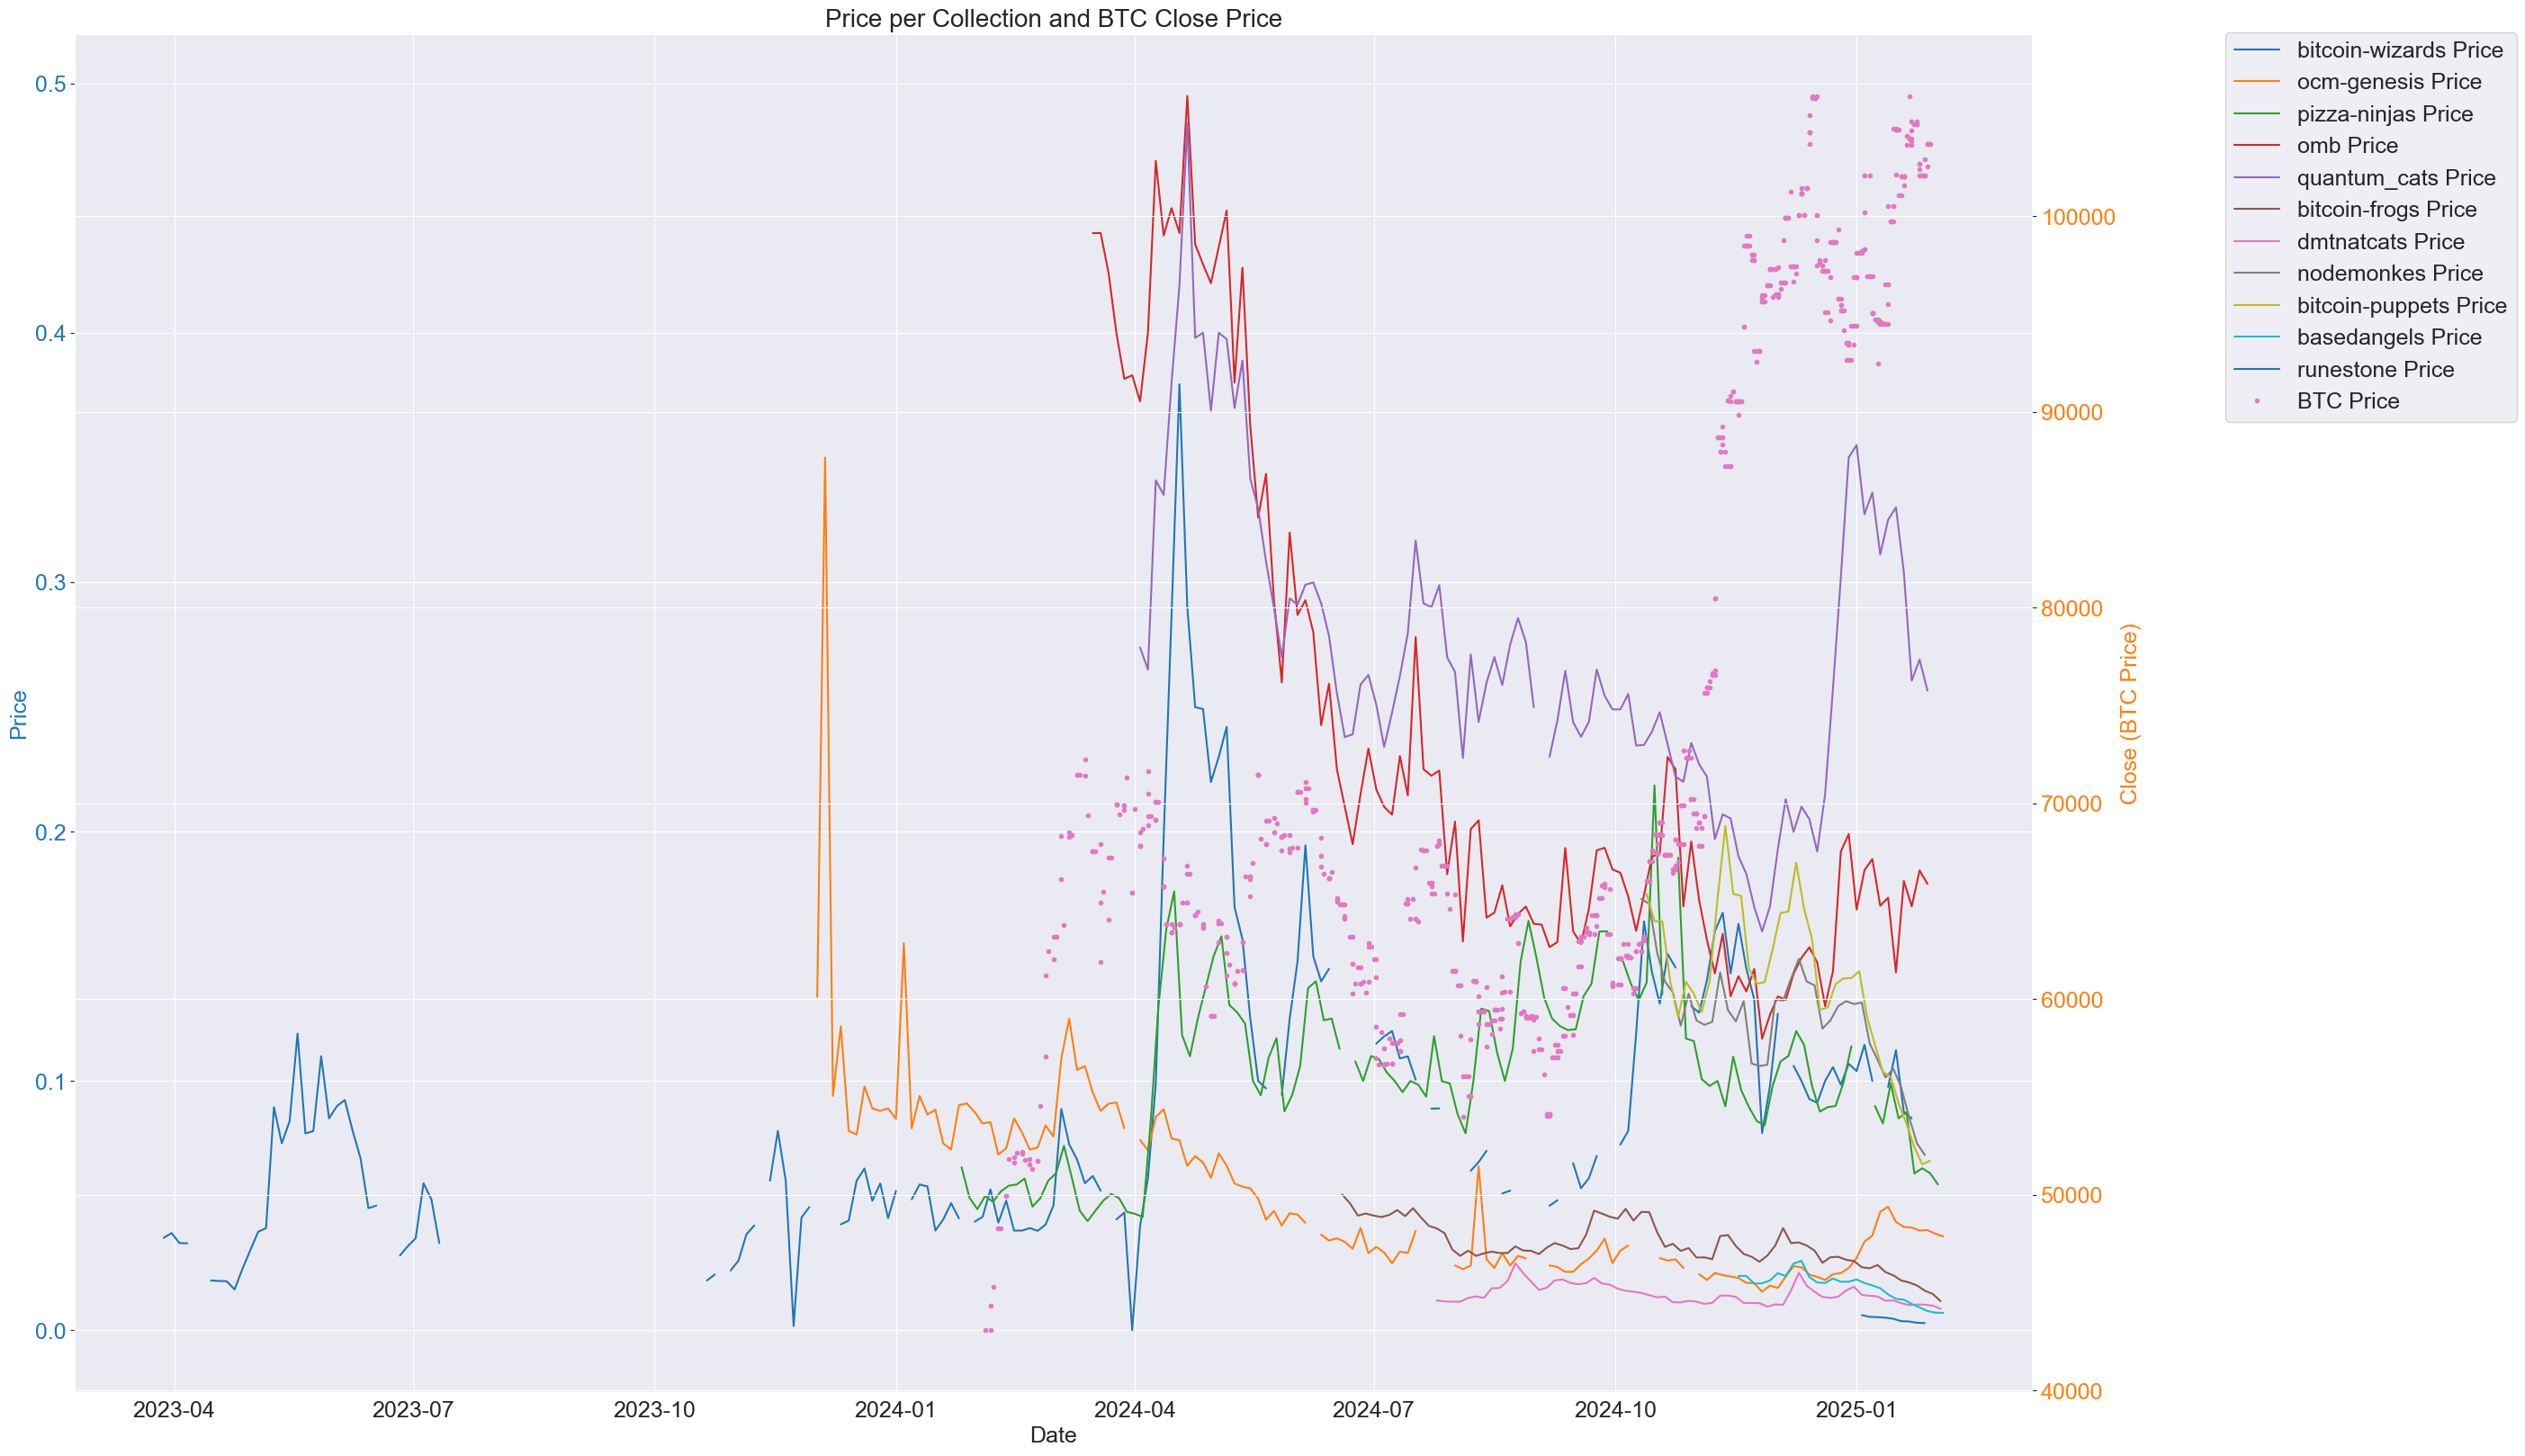

In [75]:
# Resample dataframe at the specified frequency
resample_period = '3D'
test_resample_df = resample_df(collections_df, resample_period)

# Create a plot to compare collection prices over time and Bitcoin prices
plt.figure(figsize=(24, 16))  # Set the figure size for better readability
fig, ax1 = plt.subplots(figsize=(24, 16))    # Create a plot with two y-axes for visualization

# Configure the first y-axis (collection prices)
ax1.set_xlabel('Date', fontsize=18)  # Label the x-axis as "Date" and increase font size
ax1.set_ylabel('Price', color='tab:blue', fontsize=18)  # Label the y-axis for collection prices and increase font size

# Plot the collection price for each NFT collection
for collection in collections:
    # Filter the DataFrame for the current collection
    data = test_resample_df[test_resample_df['collection'] == collection]
    # Plot collection price against date with a line plot
    ax1.plot(data['date'], data['collection_price'], label=f'{collection} Price', linestyle='-', marker=None)

# Set the tick parameters and color for the y-axis with increased font size
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

# Configure the secondary y-axis (Bitcoin prices)
ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
ax2.set_ylabel('Close (BTC Price)', color='tab:orange', fontsize=18)  # Label the secondary y-axis for Bitcoin prices and increase font size

# Plot Bitcoin prices against dates
ax2.plot(
    test_resample_df['date'], test_resample_df['btc_price'],
    label='BTC Price', color='tab:pink', linestyle='', marker='.'
)

# Set the tick parameters and color for the secondary y-axis with increased font size
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=18)

# Adjust the layout to make the plot elements fit neatly
fig.tight_layout()

# Add a legend for the figure with increased font size
fig.legend(loc='upper center', bbox_to_anchor=(1.1, 1.0), fontsize=18)

# Add grid lines for ease of reading the plots
plt.grid(True)

# Set the title for the plot with increased font size
plt.title('Price per Collection and BTC Close Price', fontsize=20)

# Show/save plot
if save_results:
    plt.savefig('./results/price_per_collection_btc_close.png', dpi=300, bbox_inches='tight')
else:
    plt.show()


From the above we have concluded that using the median price over a 3-day period is sufficient to get rid of outliers.

We can also see that we don't have data for all the collections over the entire history, so we are going to filter to the last couple of months. You can change *num_months_to_use* below, to include more or less data, and the collections for which there are missing data will simply be excluded.

In [76]:
num_months_to_use = 3

# Get the latest date in the collections DataFrame
latest_date = collections_df['date'].max()

# Calculate the start date by subtracting the specified number of months from the latest date
start_date = latest_date - pd.DateOffset(months=num_months_to_use)

# Determine the earliest date for each collection in the dataset
first_date_per_collection = collections_df.groupby('collection')['date'].min()

# Identify collections that do not have data starting from or before the calculated start date
excluded_collections = first_date_per_collection[first_date_per_collection >= start_date].index.unique()

# If any collections are excluded, print a warning message with their names
if len(excluded_collections) > 0:
    print(f"Warning: The following collections don't have complete data to the start date {start_date} and will be excluded: {list(excluded_collections)}")

# Filter the analysis DataFrame to include only:
# - Rows where the 'date' is on or after the calculated start date
# - Collections that are not in the excluded list
resampled_df = collections_df.copy()
resampled_df = resampled_df[(resampled_df['date'] >= start_date) &
                            (~resampled_df['collection'].isin(excluded_collections))]

# If for a given collection, resampled_df is empty for the start_date, use values for the prior available date. This ensures
# that our resampling dates coincide
for collection in resampled_df['collection'].unique():
    if start_date.date() not in resampled_df[resampled_df['collection'] == collection]['date'].dt.date.values:
        prior_date = collections_df[(collections_df['collection'] == collection) & (collections_df['date'] <= start_date)]['date'].max()
        prior_collection_price = collections_df[(collections_df['collection']==collection) & (collections_df['date'] == prior_date)]['collection_price'].max()
        prior_btc_price = btc_price_dict['btc_price'].get(start_date.date())
        new_row = {
            'collection': collection,
            'date': start_date,
            'collection_price': prior_collection_price,
            'btc_price': prior_btc_price
        }
        resampled_df = pd.concat([resampled_df, pd.DataFrame([new_row])], ignore_index=True)

# Resample using the resampling period
resampled_df = resample_df(resampled_df, resample_period)

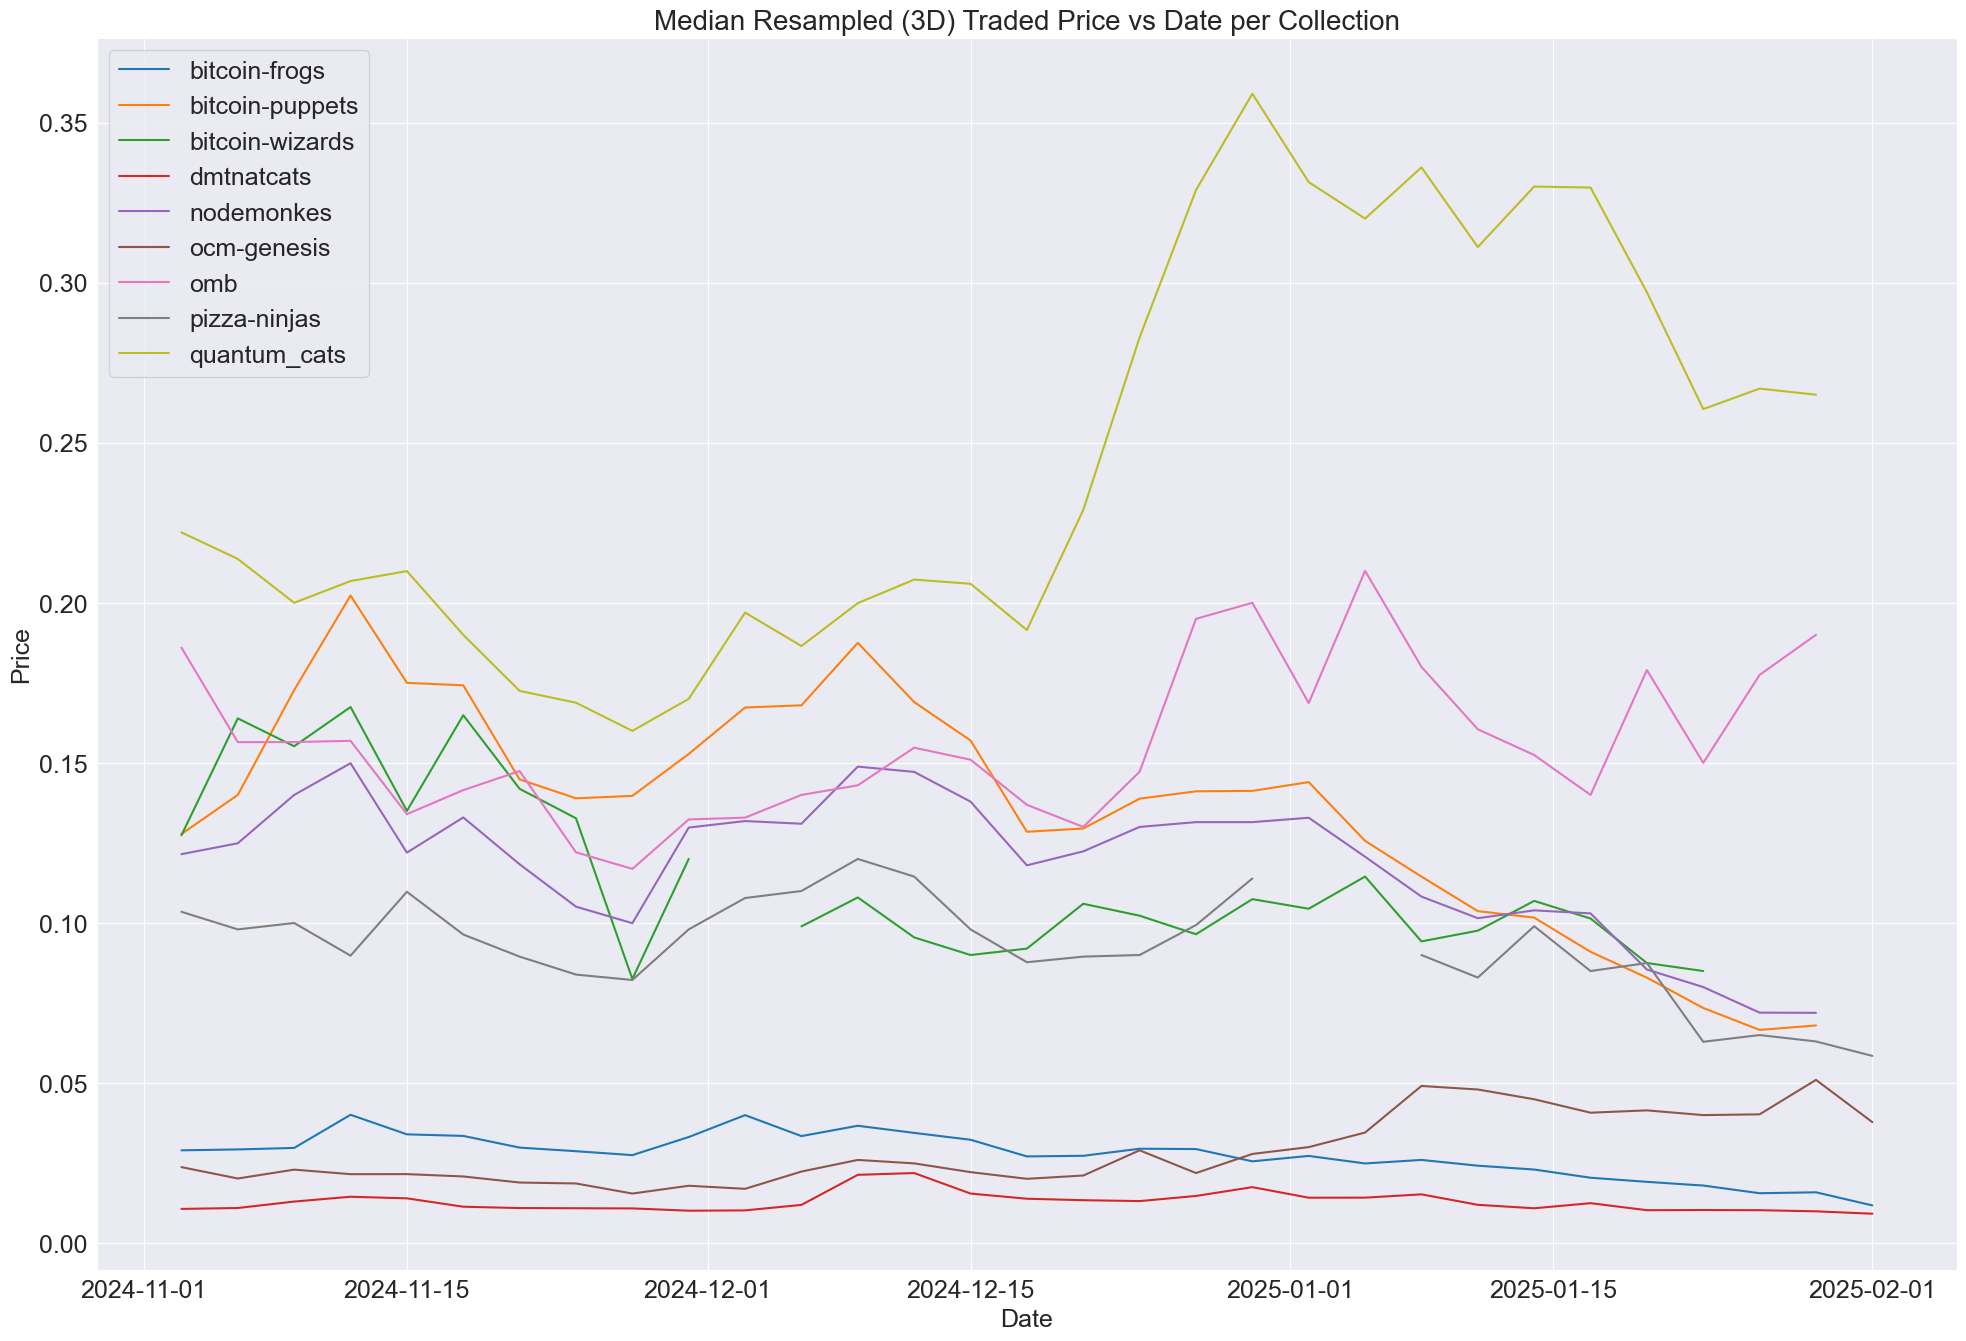

In [77]:
# Get the unique NFT collections from the cleaned and filtered dataset
collections = resampled_df['collection'].unique()

# Create a new figure for the plot with the specified size
plt.figure(figsize=(24, 16))

# Loop through each unique NFT collection
for collection in collections:
    # Filter the DataFrame to include only the rows relevant to the current collection
    collection_data = resampled_df[resampled_df['collection'] == collection]

    # Plot the collection's median resampled traded price over time
    plt.plot(
        collection_data['date'],                # The x-axis (dates)
        collection_data['collection_price'],    # The y-axis (collection prices)
        label=collection                        # Label for the legend
    )

# Add a label to the x-axis with increased font size
plt.xlabel('Date', fontsize=18)

# Add a label to the y-axis with increased font size
plt.ylabel('Price', fontsize=18)

# Add a title to the plot, dynamically including the resample period in the title, with increased font size
plt.title('Median Resampled ({}) Traded Price vs Date per Collection'.format(resample_period), fontsize=20)

# Display the legend to identify each collection by its label with increased font size
plt.legend(fontsize=18)

# Enable grid lines for better readability of the chart
plt.grid(True)

# Adjust tick parameters to increase font size for both axes
plt.tick_params(axis='both', labelsize=18)

# Show and save plot
if save_results:
    plt.savefig('./results/resampled_prices.png', dpi=300, bbox_inches='tight')

    # Save the resampled_df to an Excel file
    resampled_df.to_excel('./results/resampled_data.xlsx', index=False)
else:
    plt.show()



## Index construction and analysis

We will take a look at the return distributions of the various collections, and contrast that against the BTC return distribution over the same period.

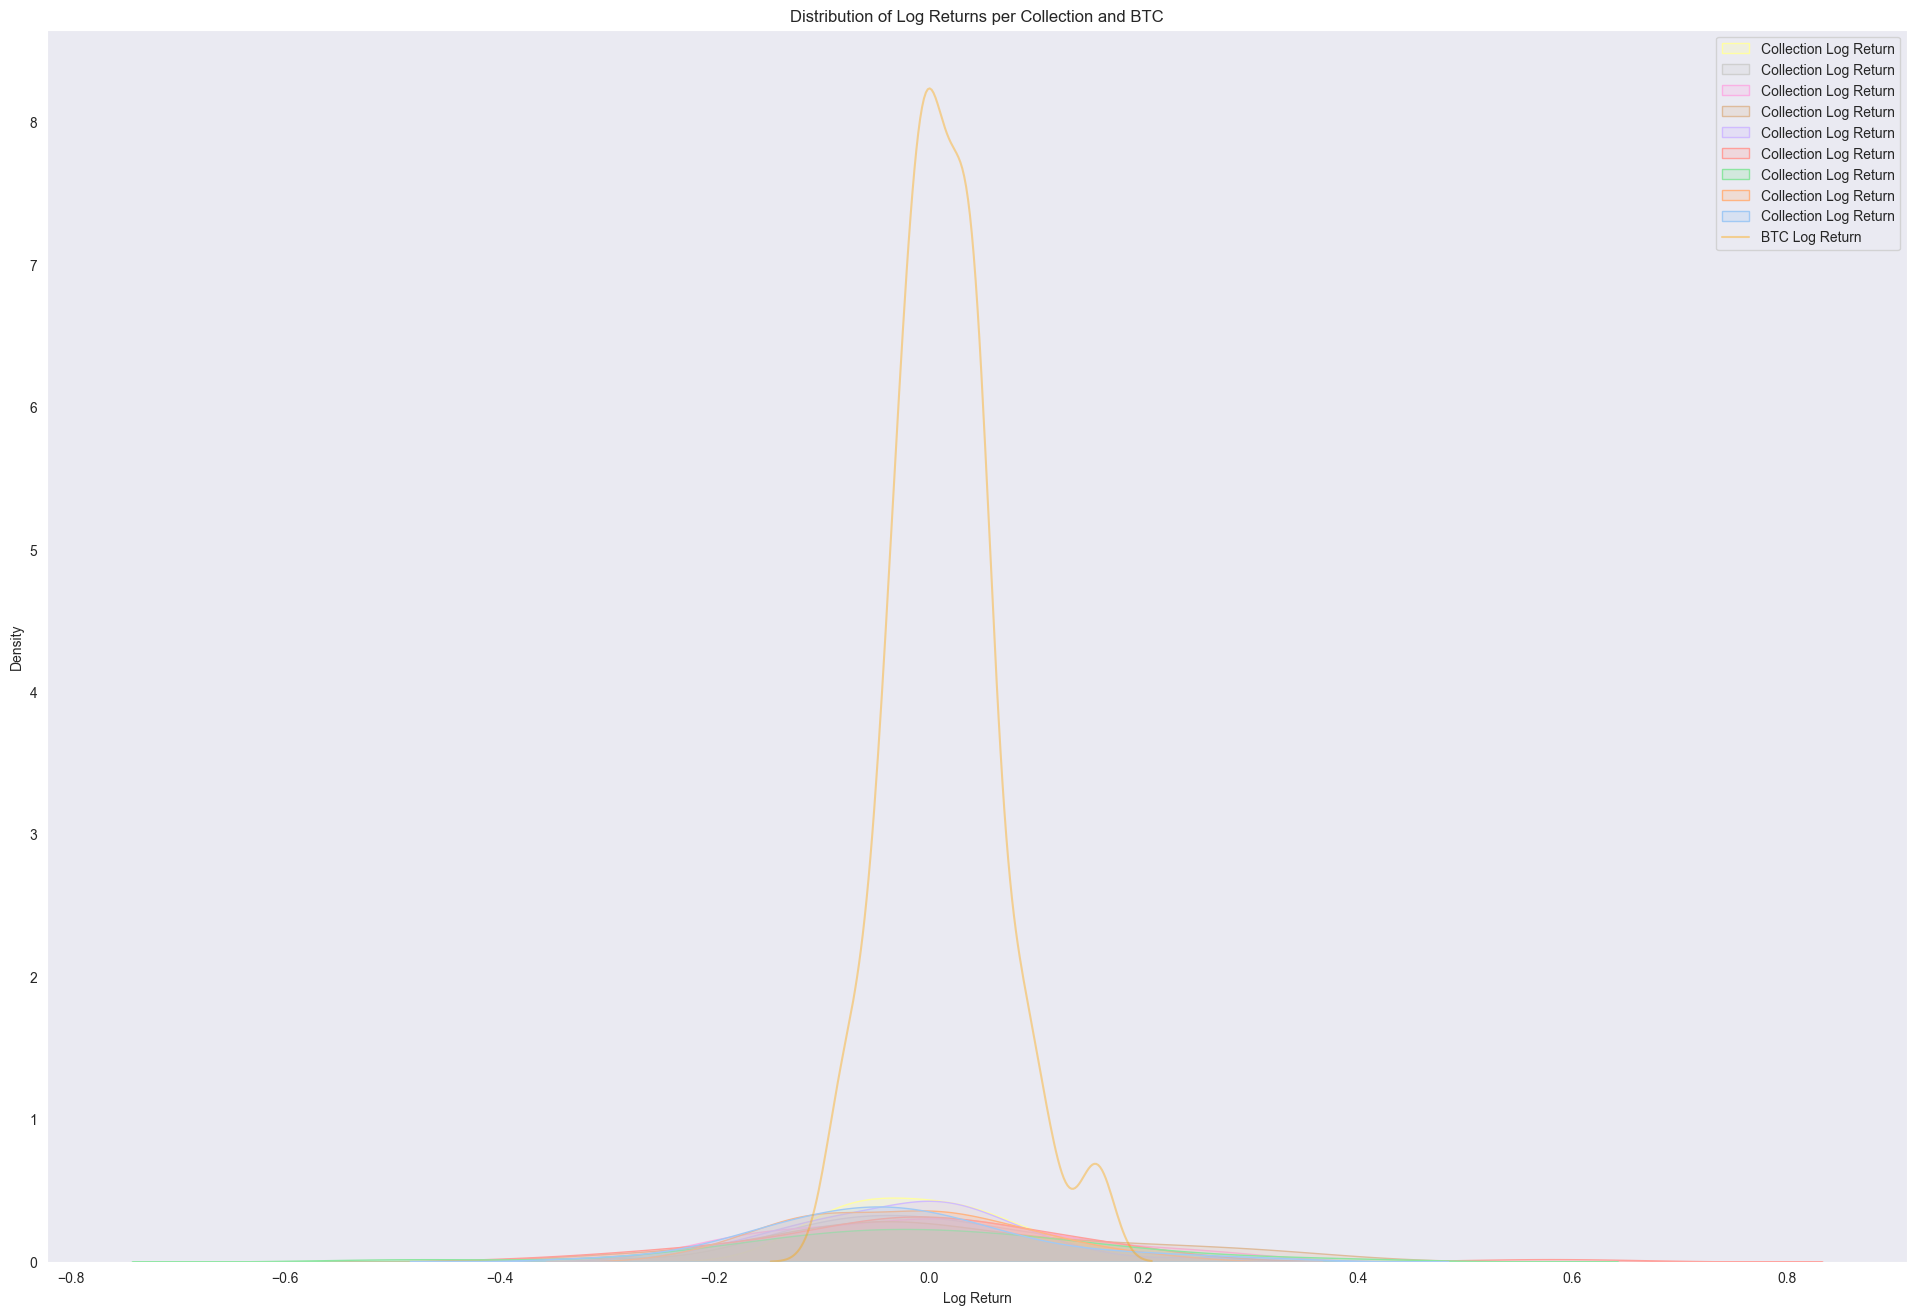

In [78]:
# Set the figure size for the plot
plt.figure(figsize=(24, 16))

# Plot the Kernel Density Estimate (KDE) for 'collection_log_return'
# - Filter out rows where 'collection_log_return' is NaN
# - Plot density for each collection, using pastel colors and filling the area under the curve
sns.kdeplot(
    data=resampled_df.dropna(subset=['collection_log_return']),  # Drop rows with missing collection_log_return
    x='collection_log_return',  # Log return of collections
    hue='collection',           # Differentiate by collection
    palette='pastel',           # Use pastel colors for the plot
    fill=True,                  # Fill the area under the density curve
    label='Collection Log Return'
)

# Plot the KDE for 'btc_log_return'
# - Filter out rows where 'btc_log_return' is NaN
# - Use orange color, without filling, and with some transparency
sns.kdeplot(
    data=resampled_df.dropna(subset=['btc_log_return']),  # Drop rows with missing btc_log_return
    x='btc_log_return',         # Log return of Bitcoin
    color='orange',             # Use orange color
    fill=False,                 # Do not fill the area under the curve
    alpha=0.4,                  # Set transparency for better visualization
    label='BTC Log Return'      # Add a label for Bitcoin log return
)

# Set the x-axis label to 'Log Return'
plt.xlabel('Log Return')

# Set the y-axis label to 'Density'
plt.ylabel('Density')

# Set the title of the plot to 'Distribution of Log Returns per Collection and BTC'
plt.title('Distribution of Log Returns per Collection and BTC')

# Display the legend to identify the KDE plots
plt.legend()

# Add gridlines to the plot for improved readability
plt.grid()

# Show the resulting plot
if save_results:
    plt.savefig('./results/log_returns.png', dpi=300, bbox_inches='tight')
else:
    plt.show()

We see similar fat-tailed distributions for the various ordinals collections.

Let's create an index for ordinal prices. We will do this by equally weighting the constituent prices, normalizing to an initial index level of 100.0.

In [84]:
# Transform 'resampled_df' by computing:
# - The average of 'collection_price' across collections for each day
# - The sum of 'collection_log_return' across collections for each day

# Group by 'date' to perform the aggregation
index_df = resampled_df.copy().groupby('date').agg({
    'collection_price': 'mean',           # Average collection price across collections
    'btc_price': 'mean',                  # Average BTC price each day, which will return the BTC price as there is one price per day
    'btc_log_return': 'mean',             # Average BTC log return each day, which will return the BTC return as there is one price per day
}).reset_index()  # Reset the index to keep 'date' as a column
index_df = index_df.rename(columns={'collection_price': 'index_btc_price'})  # Rename 'price' column for clarity

# Calculate the index factor by dividing 100 by the collection_price for the first date
first_date_price = index_df.loc[0, 'index_btc_price'] * index_df.loc[0, 'btc_price']
index_level = 100.0
index_factor = index_level / first_date_price

# Calculate the index price each day as the product of the bitcoin price, the index price in bitcoin, and the index factor
index_df['index_usd_price'] = index_level  # Initialize the first value using the index factor
for i in range(1, len(index_df)):
    index_btc_price = index_df.loc[i, 'index_btc_price']
    btc_price = index_df.loc[i, 'btc_price']
    index_price = index_btc_price * btc_price * index_factor
    index_df.loc[i, 'index_usd_price'] = index_price

# Calculate log returns for the index based on 'index_btc_price'
index_df['index_log_return'] = index_df['index_usd_price'].transform(lambda x: np.log(x / x.shift(1)))

# Drop rows with NaN or Inf values in the dataset
index_df = index_df.replace([np.inf, -np.inf], np.nan).dropna()

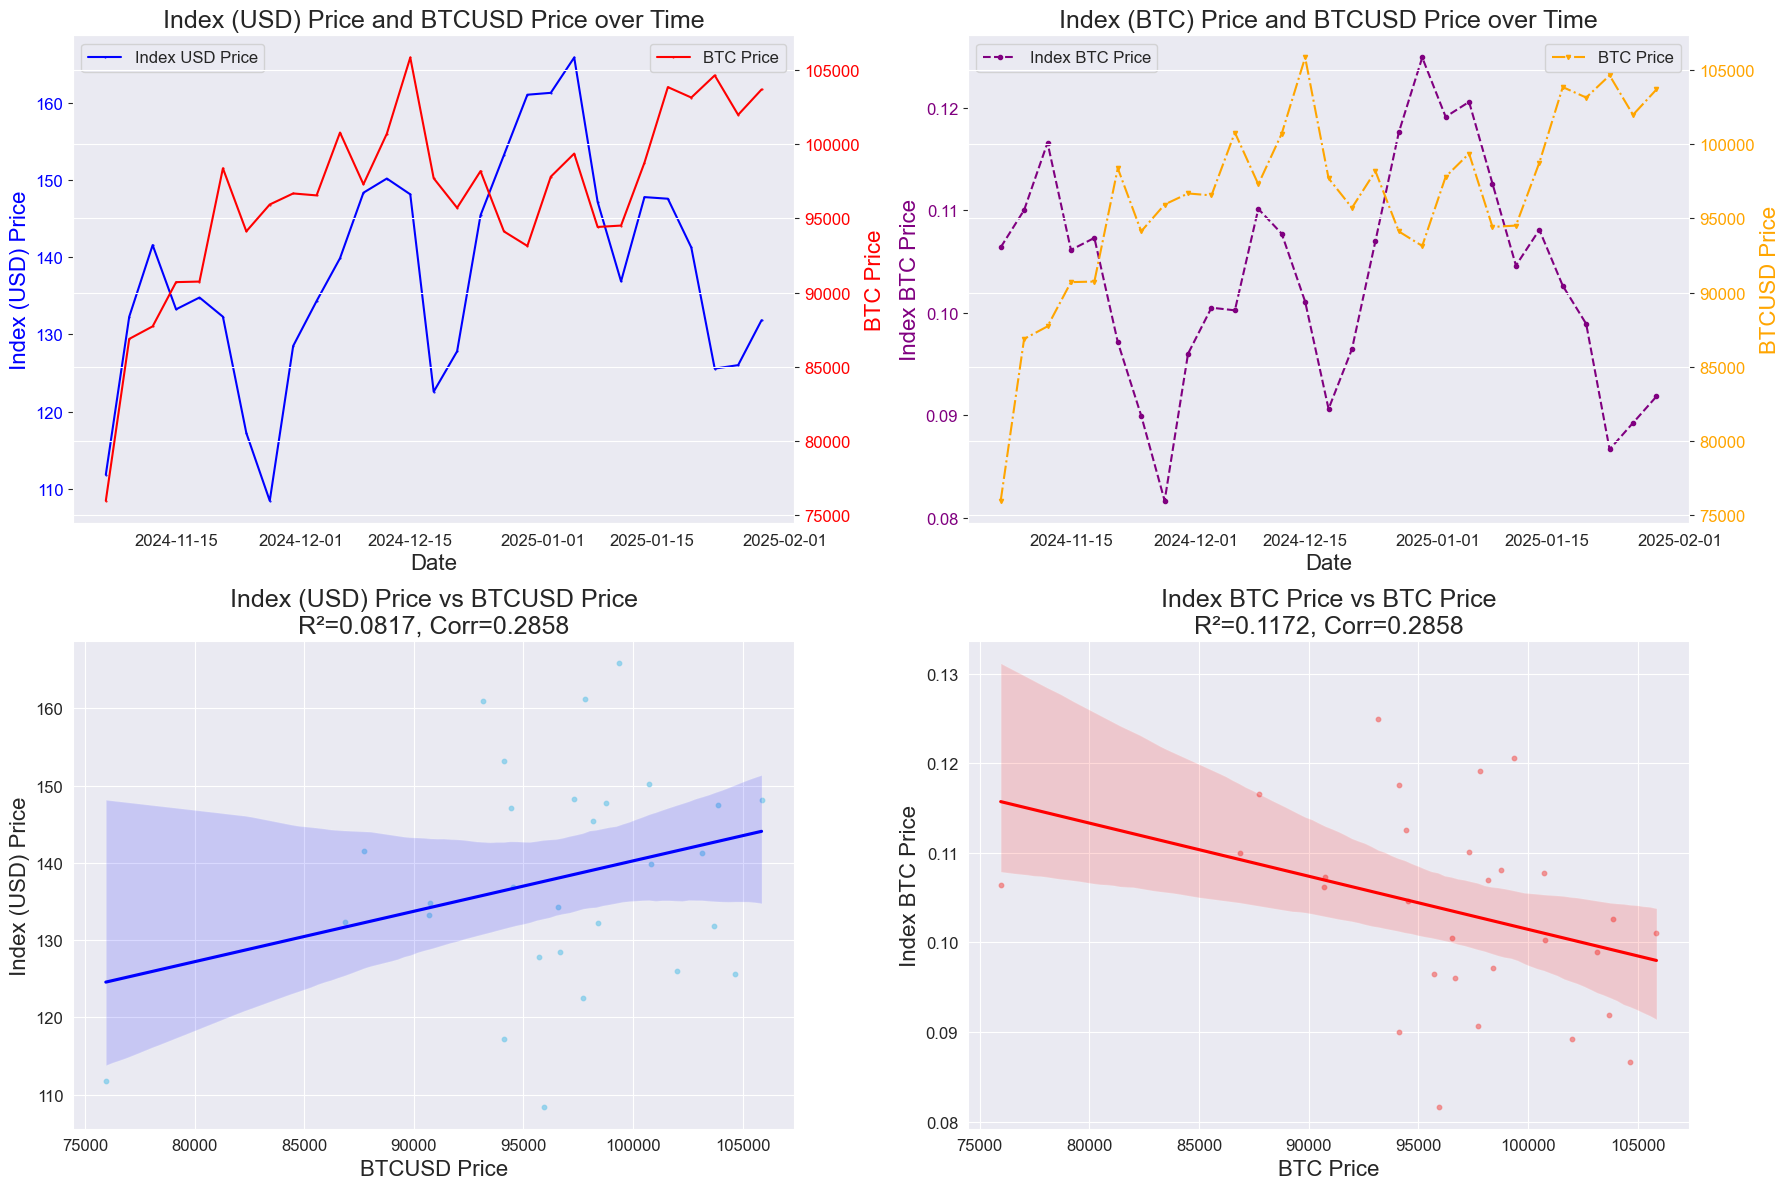

In [85]:
# Plots of Index (USD) and Index (BTC) against BTC, over time, and corresponding scatter plots to establish whether there is correlation

# Create a new figure with a 2x2 grid for the four subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# First subplot: Plot index USD price and BTC price on separate y-axes (original implementation)
ax1.plot(
    index_df['date'],  # X-axis: Date
    index_df['index_usd_price'],  # Y-axis: Index USD Price
    marker='.',  # Use dot markers for data points
    linestyle='-',  # Use a solid line to connect the points
    markersize=1,  # Set the marker size to 1 for a clean plot
    label='Index USD Price',  # Label for the plot legend
    color='blue'
)

ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Index (USD) Price', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

ax1_2 = ax1.twinx()
ax1_2.plot(
    index_df['date'],
    index_df['btc_price'],
    marker='.',
    linestyle='-',
    markersize=1,
    color='red',
    label='BTC Price'
)

ax1_2.set_ylabel('BTC Price', color='red', fontsize=16)
ax1_2.tick_params(axis='y', labelcolor='red', labelsize=12)

ax1.set_title('Index (USD) Price and BTCUSD Price over Time', fontsize=18)
ax1.grid()
ax1.legend(loc='upper left', fontsize=12)
ax1_2.legend(loc='upper right', fontsize=12)

# Second subplot: Plot index_btc_price and BTC price
ax2.plot(
    index_df['date'],
    index_df['index_btc_price'],
    marker='o',
    linestyle='--',
    markersize=3,
    label='Index BTC Price',
    color='purple'
)

ax2.set_xlabel('Date', fontsize=16)
ax2.set_ylabel('Index BTC Price', color='purple', fontsize=16)
ax2.tick_params(axis='y', labelcolor='purple', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)

ax2_2 = ax2.twinx()
ax2_2.plot(
    index_df['date'],
    index_df['btc_price'],
    marker='v',
    linestyle='-.',
    markersize=3,
    label='BTC Price',
    color='orange'
)

ax2_2.set_ylabel('BTCUSD Price', color='orange', fontsize=16)
ax2_2.tick_params(axis='y', labelcolor='orange', labelsize=12)

ax2.set_title('Index (BTC) Price and BTCUSD Price over Time', fontsize=18)
ax2.grid()
ax2.legend(loc='upper left', fontsize=12)
ax2_2.legend(loc='upper right', fontsize=12)

# Third subplot: Scatterplot of index_usd_price against btc_price with regression
sns.regplot(
    ax=ax3,
    x='btc_price',
    y='index_usd_price',
    data=index_df,
    scatter_kws={'s': 10, 'color': 'skyblue'},
    line_kws={'color': 'blue'}
)

# Use scipy's linregress for regression analysis
lin_reg_results = linregress(index_df['btc_price'], index_df['index_usd_price'])
r_value, slope, intercept = lin_reg_results.rvalue, lin_reg_results.slope, lin_reg_results.intercept
r_squared = r_value**2

correlation = np.corrcoef(index_df['btc_price'], index_df['index_usd_price'])[0, 1]

ax3.set_title(f'Index (USD) Price vs BTCUSD Price\nR²={r_squared:.4f}, Corr={correlation:.4f}', fontsize=18)
ax3.set_xlabel('BTCUSD Price', fontsize=16)
ax3.set_ylabel('Index (USD) Price', fontsize=16)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.grid(True)

# Fourth subplot: Scatterplot of index_btc_price against btc_price with regression
sns.regplot(
    ax=ax4,
    x='btc_price',
    y='index_btc_price',
    data=index_df,
    scatter_kws={'s': 10, 'color': 'lightcoral'},
    line_kws={'color': 'red'}
)

# Use scipy's linregress for regression analysis
lin_reg_results = linregress(index_df['btc_price'], index_df['index_btc_price'])
r_value, slope, intercept = lin_reg_results.rvalue, lin_reg_results.slope, lin_reg_results.intercept
r_squared = r_value**2

ax4.set_title(f'Index BTC Price vs BTC Price\nR²={r_squared:.4f}, Corr={correlation:.4f}', fontsize=18)
ax4.set_xlabel('BTC Price', fontsize=16)
ax4.set_ylabel('Index BTC Price', fontsize=16)
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.grid(True)

# Adjust layout and show/save the plot
plt.tight_layout()
if save_results:
    plt.savefig('./results/index_price_comparison_with_scatterplots.png', dpi=300, bbox_inches='tight')
else:
    plt.show()


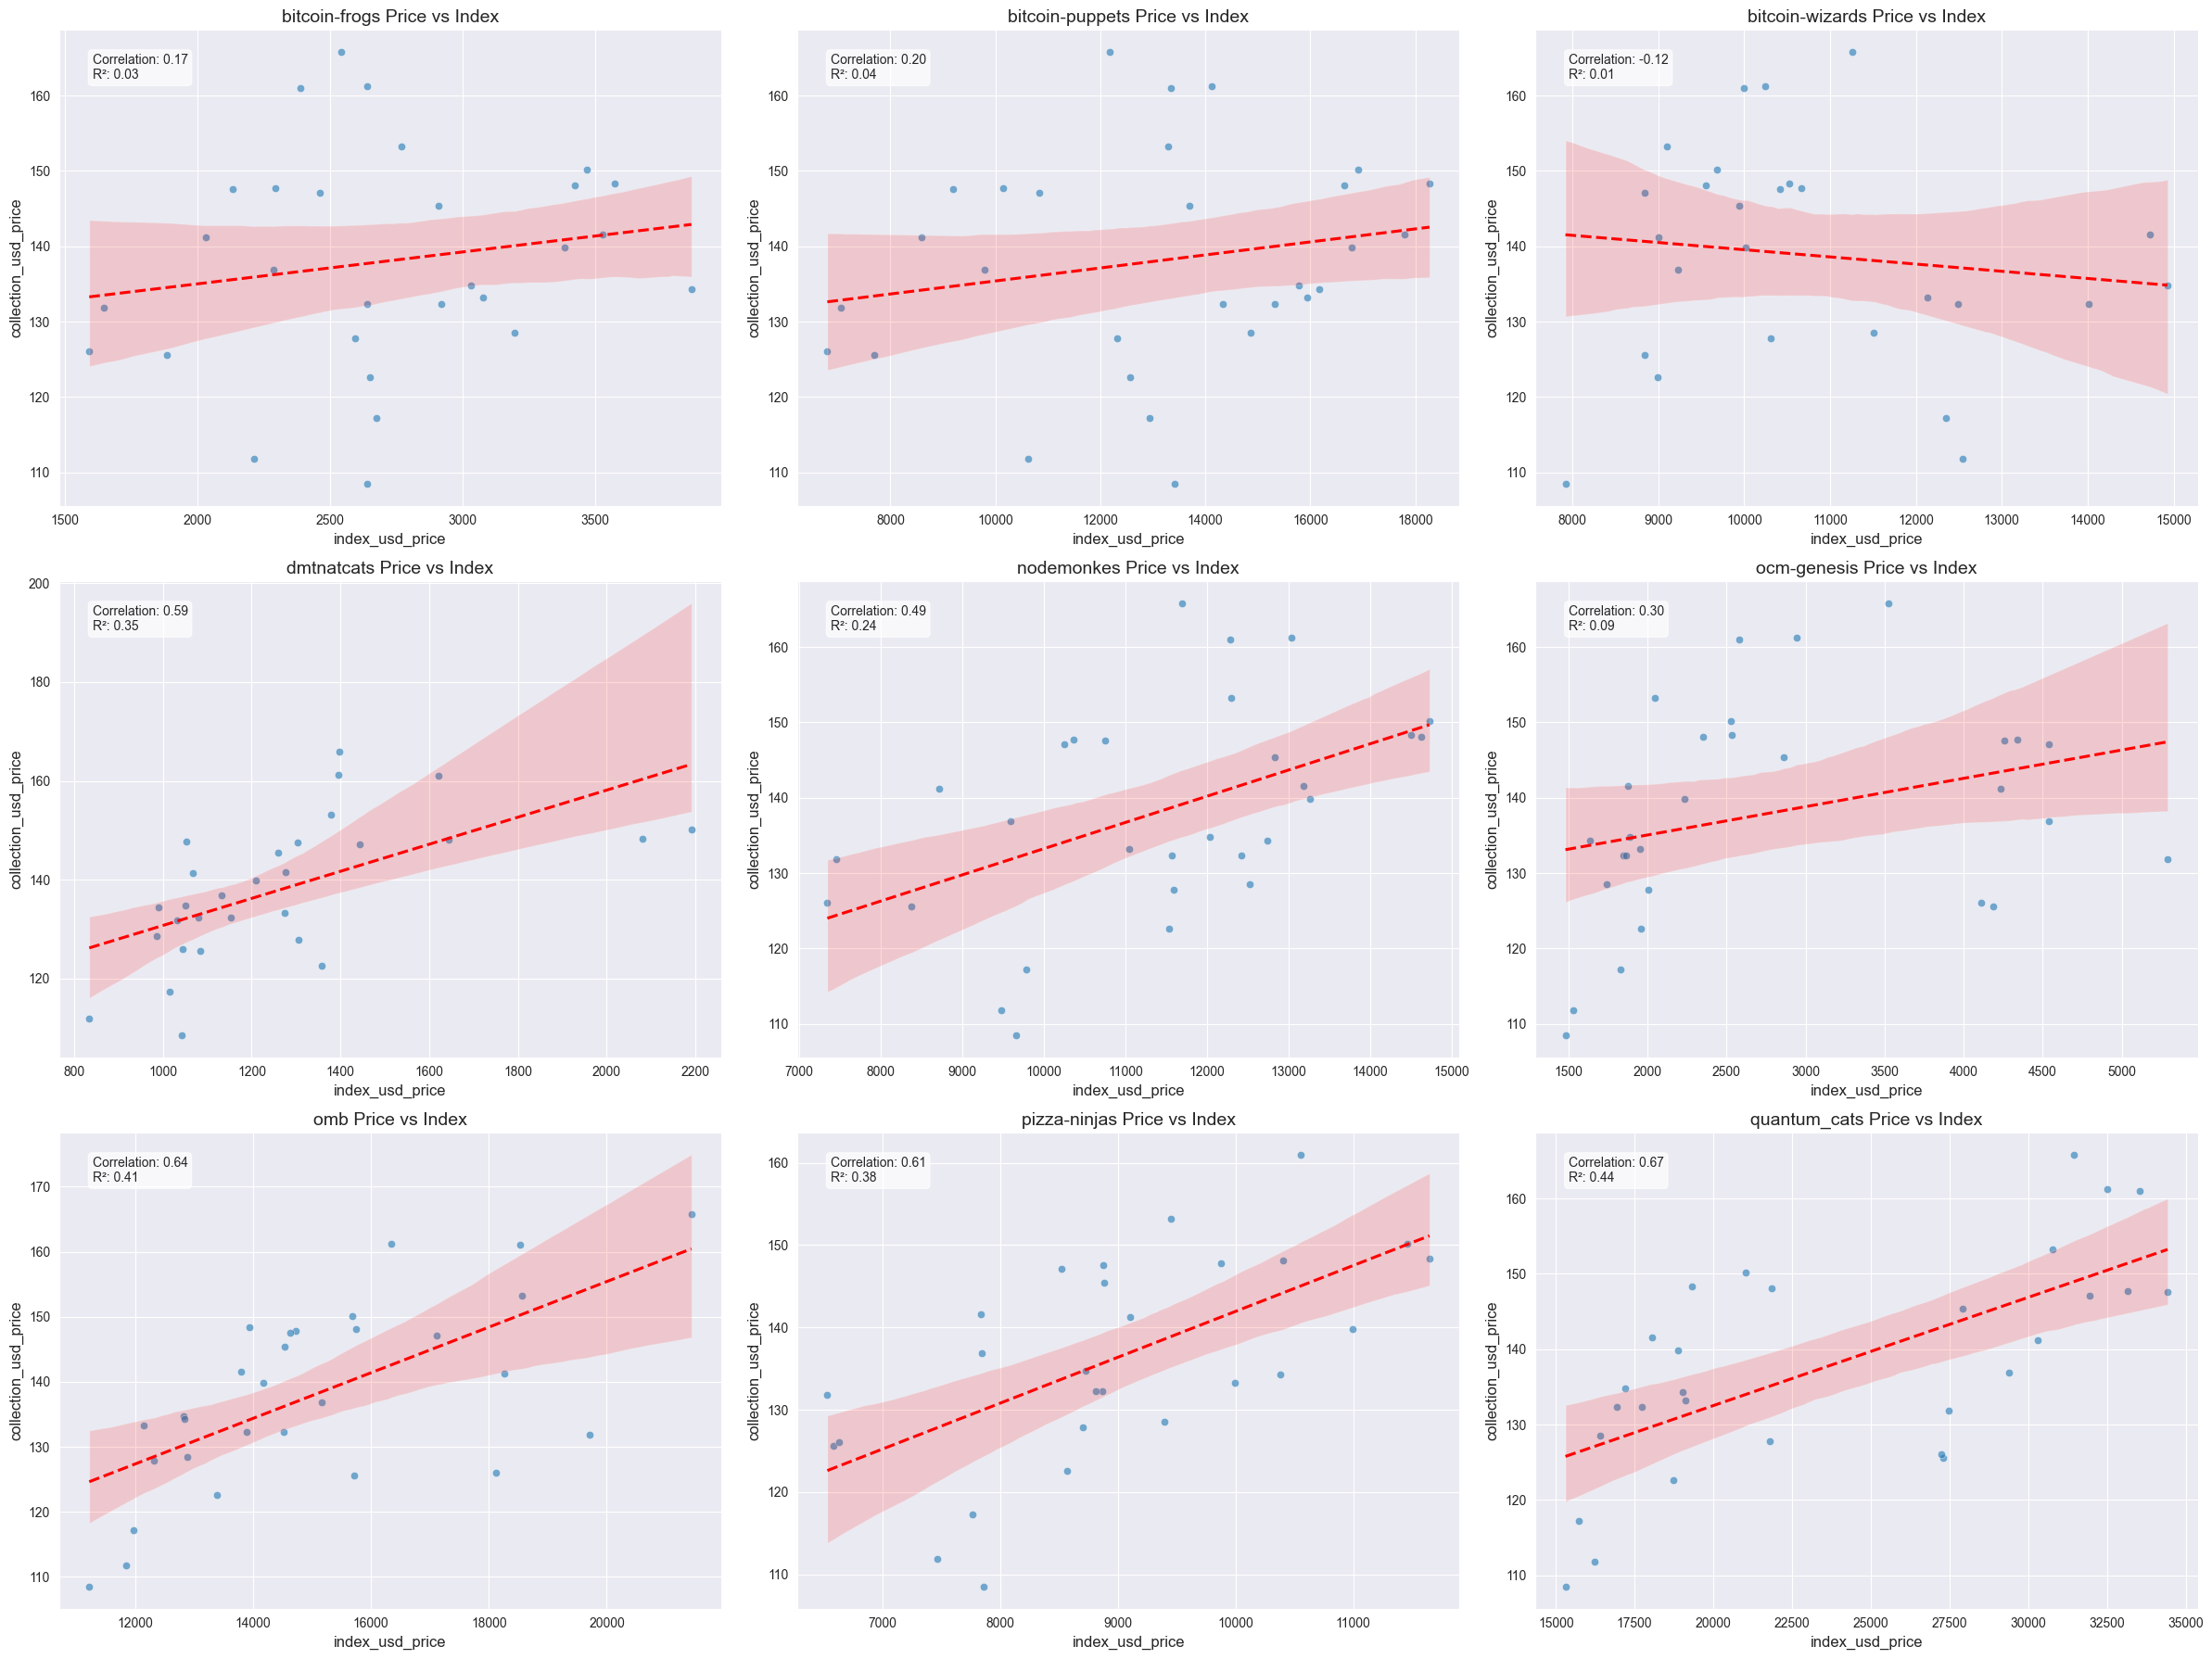

In [90]:
# Create a grid of scatterplots to show index_metric against collection_metric for each collection
index_metric = 'index_usd_price'  # index_btc_price or index_usd_price
collection_metric = 'collection_usd_price'  # collection_price or collection_usd_price

# Create a new figure for the grid of scatterplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))  # Adjust the grid size as needed (3x3 here for 9 collections)
axes = axes.flatten()  # Flatten the axes array to loop through each subplot

# Trim or use collections only to fit the number of subplots
collections_to_plot = collections[:len(axes)]

# Loop through the collections and create scatterplots
for i, collection in enumerate(collections_to_plot):
    ax = axes[i]
    # Filter data for the current collection
    collection_data = resampled_df[resampled_df['collection'] == collection]
    # Ensure that both x and y axes have valid data
    if not collection_data.empty and not index_df.empty:
        # Match `index_usd_price` with `collection_usd_price` by `date`
        merged_data = pd.merge(
            index_df[['date', index_metric]],
            collection_data[['date', collection_metric]],
            on='date',
            how='inner'
        )

        # Drop rows with NaN or infinite values in either column
        merged_data = merged_data[
            merged_data[[collection_metric, index_metric]].apply(pd.to_numeric, errors='coerce').notnull().all(axis=1)
        ]

        # Plot scatterplot for index_metric vs collection_metric
        sns.scatterplot(
            x=merged_data[collection_metric],
            y=merged_data[index_metric],
            ax=ax,
            alpha=0.6
        )

        # Perform linear regression if there is sufficient valid data
        if len(merged_data) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(
                merged_data[collection_metric],
                merged_data[index_metric]
            )

            # Add regression line using Seaborn
            sns.regplot(
                x=merged_data[collection_metric],
                y=merged_data[index_metric],
                ax=ax,
                scatter=False,  # Disable scatter to avoid duplicate points
                color='red',
                line_kws={"linestyle": "--", "label": f'Reg: y={slope:.2f}x+{intercept:.2f}'}
            )

            # Add correlation and r^2 as text
            ax.text(
                0.05, 0.95,
                f'Correlation: {r_value:.2f}\nR²: {r_value**2:.2f}',
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
            )
        else:
            ax.text(0.5, 0.5, 'Insufficient Data for Regression', ha='center', va='center', fontsize=10)

        # Set title and labels
        ax.set_title(f'{collection} Price vs Index', fontsize=14)
        ax.set_xlabel(index_metric, fontsize=12)
        ax.set_ylabel(collection_metric, fontsize=12)
        ax.grid(True)
    else:
        # Handle empty data cases
        ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12)
        ax.set_title(f'{collection}', fontsize=14)
        ax.set_xlabel(index_metric, fontsize=12)
        ax.set_ylabel(collection_metric, fontsize=12)
        ax.grid(False)

# Hide any extra subplots if collections are fewer than the grid size
for j in range(len(collections_to_plot), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping
fig.tight_layout()

# Show the plot
plt.show()

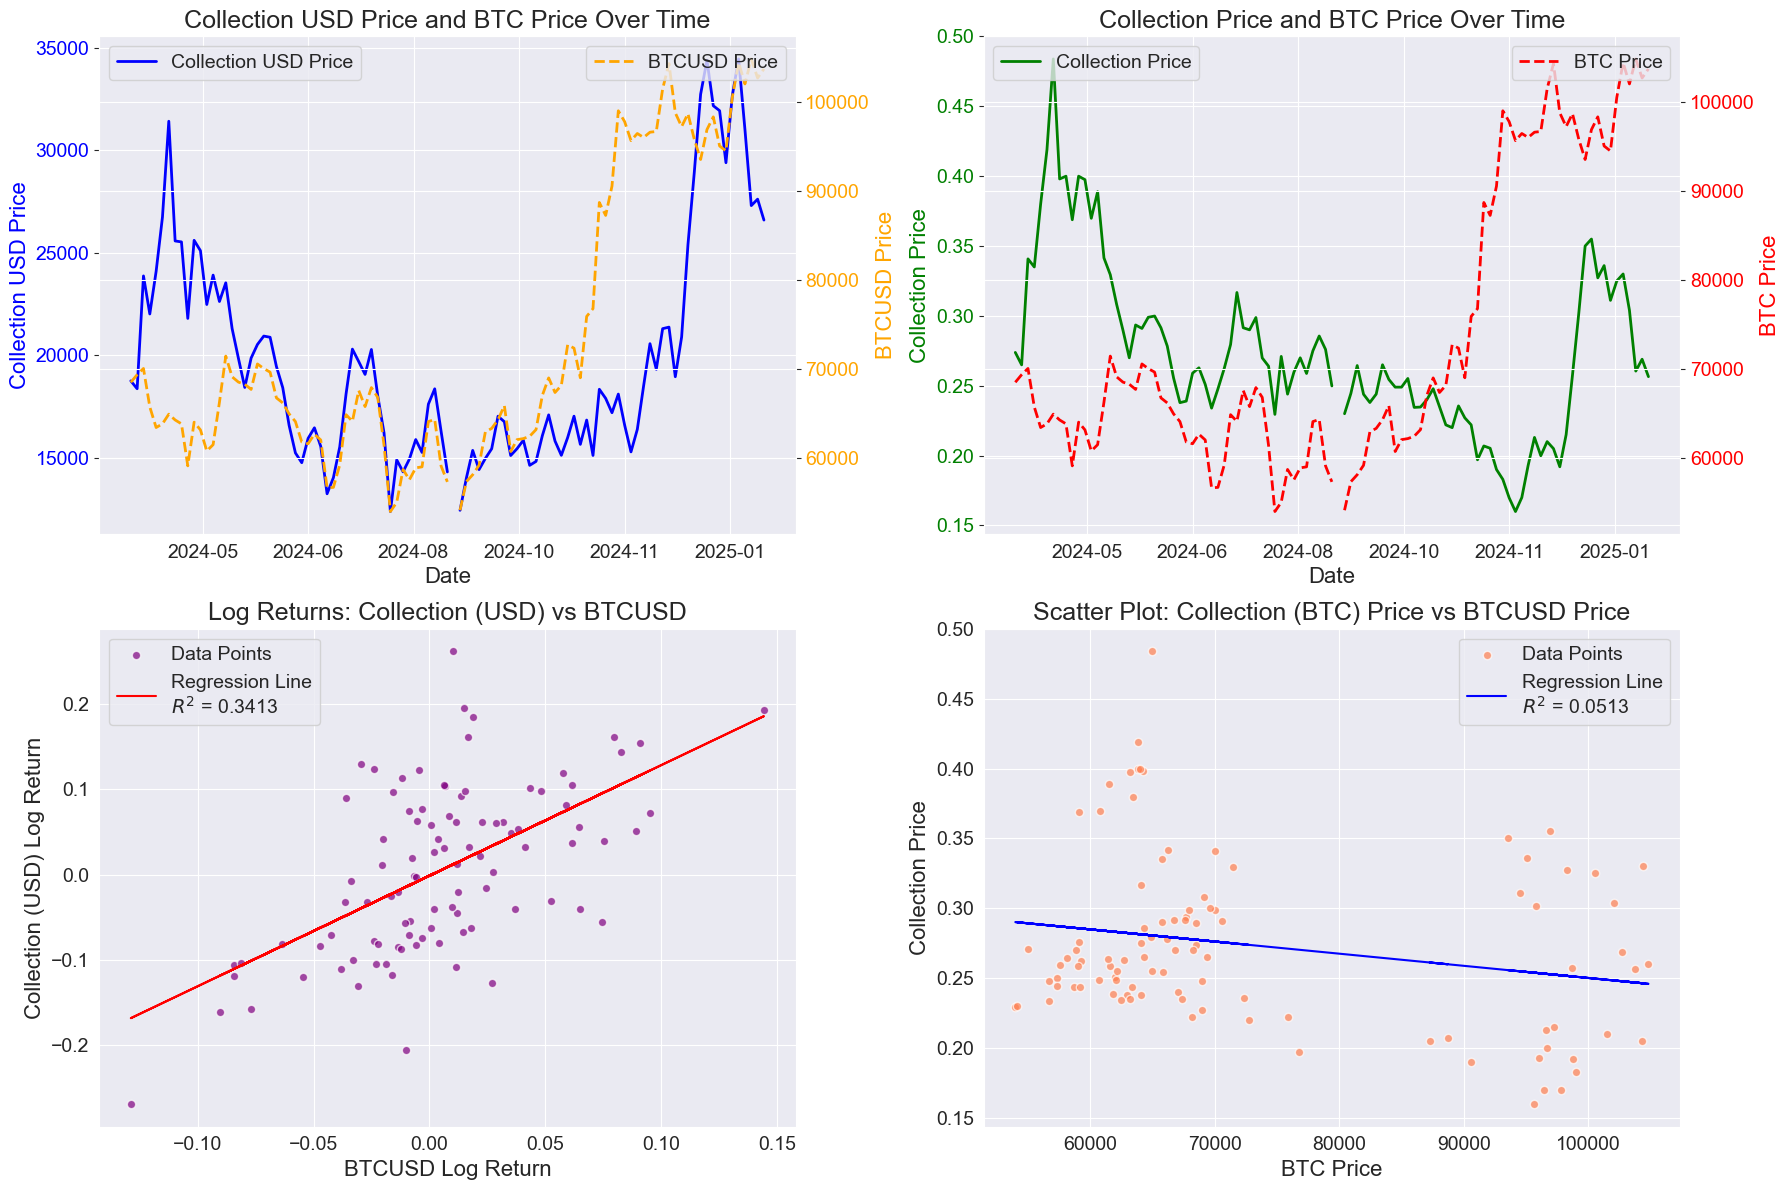

In [93]:
# Create a figure with a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # Adjusted to include four plots

collection_resampled_df = resample_df(collections_df, resample_period)

collection_df = collection_resampled_df[collection_resampled_df['collection'] == 'quantum_cats']

# First plot: Collection USD Price and BTC Price over time
ax1 = axes[0, 0]
ax1.plot(
    collection_df['date'],
    collection_df['collection_usd_price'],
    label='Collection USD Price',
    color='blue',
    linewidth=2
)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Collection USD Price', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax1.tick_params(axis='x', labelsize=14)
ax1.legend(loc='upper left', fontsize=14)
ax1.grid(True)

ax1_2 = ax1.twinx()
ax1_2.plot(
    collection_df['date'],
    collection_df['btc_price'],
    label='BTCUSD Price',
    color='orange',
    linewidth=2,
    linestyle='--'
)
ax1_2.set_ylabel('BTCUSD Price', color='orange', fontsize=16)
ax1_2.tick_params(axis='y', labelcolor='orange', labelsize=14)
ax1_2.legend(loc='upper right', fontsize=14)
ax1.set_title('Collection USD Price and BTC Price Over Time', fontsize=18)

# Second plot in the first row: Collection Price and BTC Price on two axes
ax2 = axes[0, 1]
ax2.plot(
    collection_df['date'],
    collection_df['collection_price'],
    label='Collection Price',
    color='green',
    linewidth=2
)
ax2.set_xlabel('Date', fontsize=16)
ax2.set_ylabel('Collection Price', color='green', fontsize=16)
ax2.tick_params(axis='y', labelcolor='green', labelsize=14)
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax2.tick_params(axis='x', labelsize=14)
ax2.legend(loc='upper left', fontsize=14)
ax2.grid(True)

ax2_2 = ax2.twinx()
ax2_2.plot(
    collection_df['date'],
    collection_df['btc_price'],
    label='BTC Price',
    color='red',
    linewidth=2,
    linestyle='--'
)
ax2_2.set_ylabel('BTC Price', color='red', fontsize=16)
ax2_2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2_2.legend(loc='upper right', fontsize=14)
ax2.set_title('Collection Price and BTC Price Over Time', fontsize=18)

# First plot in the second row: Scatter plot of USD log return vs BTC log return
ax3 = axes[1, 0]
filtered_df = collection_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['collection_usd_log_return', 'btc_log_return'])
slope, intercept, r_value, p_value, std_err = linregress(filtered_df['btc_log_return'], filtered_df['collection_usd_log_return'])

ax3.scatter(
    filtered_df['btc_log_return'],
    filtered_df['collection_usd_log_return'],
    alpha=0.7,
    color='purple',
    edgecolor='w',
    label='Data Points'
)
ax3.plot(
    filtered_df['btc_log_return'],
    slope * filtered_df['btc_log_return'] + intercept,
    color='red',
    label=f'Regression Line\n$R^2$ = {r_value**2:.4f}'
)
ax3.set_xlabel('BTCUSD Log Return', fontsize=16)
ax3.set_ylabel('Collection (USD) Log Return', fontsize=16)
ax3.tick_params(axis='both', labelsize=14)
ax3.grid(True)
ax3.legend(fontsize=14)
ax3.set_title('Log Returns: Collection (USD) vs BTCUSD', fontsize=18)

# Second plot in the second row: Scatter plot of Collection Price vs BTC Price
ax4 = axes[1, 1]
filtered_price_df = collection_df.dropna(subset=['collection_price', 'btc_price'])
price_slope, price_intercept, price_r_value, _, _ = linregress(filtered_price_df['btc_price'], filtered_price_df['collection_price'])

ax4.scatter(
    filtered_price_df['btc_price'],
    filtered_price_df['collection_price'],
    alpha=0.7,
    color='coral',
    edgecolor='w',
    label='Data Points'
)
ax4.plot(
    filtered_price_df['btc_price'],
    price_slope * filtered_price_df['btc_price'] + price_intercept,
    color='blue',
    label=f'Regression Line\n$R^2$ = {price_r_value**2:.4f}'
)
ax4.set_xlabel('BTC Price', fontsize=16)
ax4.set_ylabel('Collection Price', fontsize=16)
ax4.tick_params(axis='both', labelsize=14)
ax4.grid(True)
ax4.legend(fontsize=14)
ax4.set_title('Scatter Plot: Collection (BTC) Price vs BTCUSD Price', fontsize=18)

# Adjust the layout to fit all plots
fig.tight_layout()

# Show or save the plots
if save_results:
    plt.savefig('./results/rearranged_plots.png', dpi=300, bbox_inches='tight')
else:
    plt.show()

From this we can see that ordinals Index price (in USD) and the BTC price is not correlated.

Let's look at summary statistics of the ordinals index returns against the btc returns.

In [82]:
# Print HTML summary statistics of index_df
from IPython.display import display, HTML

# Convert the statistical analysis of the DataFrame into HTML and display it
index_df_summary = index_df.describe()
display(HTML(index_df_summary.to_html()))

,date,index_btc_price,btc_price,btc_log_return,index_usd_price,index_log_return
count,29,29.000000,29.000000,29.000000,29.000000,29.000000
mean,2024-12-18 00:00:00,0.103513,96536.887795,0.014267,138.006167,0.009531
min,2024-11-06 00:00:00,0.081679,75952.567778,-0.080101,108.466686,-0.189315
25%,2024-11-27 00:00:00,0.096471,94131.694444,-0.010449,128.501095,-0.043701
50%,2024-12-18 00:00:00,0.104615,97306.505000,0.014462,136.867699,0.012297
75%,2025-01-08 00:00:00,0.110018,100722.365000,0.042428,147.769096,0.052232
max,2025-01-29 00:00:00,0.124894,105862.024444,0.133543,165.838902,0.169494
std,NaN,0.010777,6225.203498,0.046411,14.213101,0.085982


As expected, we can see the volatility (as measured by the standard deviation, column `std`) of the ordinals Index is significantly higher than that of BTC. This stands to reason given that ordinals are still in their infancy.

## Closing remarks

